# Sweet Lift Taxi Order Forecasting


Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.


## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic, adfuller
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0)           # Prevent line wrapping
pd.set_option('display.max_colwidth', None) # Show full contents of cells
warnings.filterwarnings('ignore')

In [12]:
# Functions
random_state = 777

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def expm1_clip(x):
    # numerical guard: never predict negative orders
    return np.maximum(np.expm1(x), 0)

# ADF helper (Stationarity for training set)
def print_adf_result(series):
    stat, p, _, _, crit_vals, _ = adfuller(series)
    print(f'ADF Statistic: {stat:.4f}')
    print(f'p-value: {p:.4f}') # Hypothesis testing p < 0.05, reject null, data is stationary
    print('Critical Values:') # ADF stat < crit value, reject null, stationary
    for k, v in crit_vals.items():
        print(f'   {k}: {v:.4f}')

## Analysis

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



There are 26415 duplicated rows.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

<Axes: xlabel='datetime'>

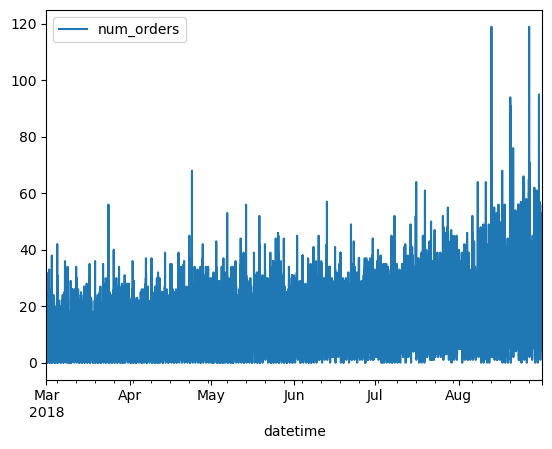

In [13]:
# Load the data
df = pd.read_csv('../data/taxi.csv', parse_dates=['datetime'], index_col=[0])
df.sort_index(inplace=True)
display(df.head())
print()
print('There are', df.duplicated().sum(), 'duplicated rows.')
print()
display(df.info())
print()
df.plot()

- The column names are formatted correctly.
- There are no missing values, and the datatypes were pre-emptively corrected such that the `datetime` column was parsed as the correct **datetime** datatype.
- For straightforward modeling, the `dateteime` column was also preemptively converted to the index column, successfully converting `df` to a **Series**.
- There are many duplicates in `num_orders` now that we've made the conversion of the `datetime` column from unique identifier to indexing column - there will inevitable be repeat numbers of orders on any given day.
- As the data was collected in 10 minute increments for months on end, the plot is understandably noisy and difficult to discern any kind of trend or seasonality.
    - The data shall be resampled in hourly increments in the next code block.

<Axes: title={'center': 'March w/ 10-Hour Rolling Mean'}, xlabel='datetime'>

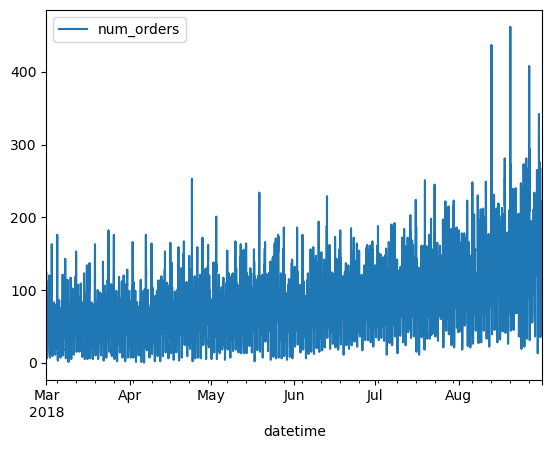

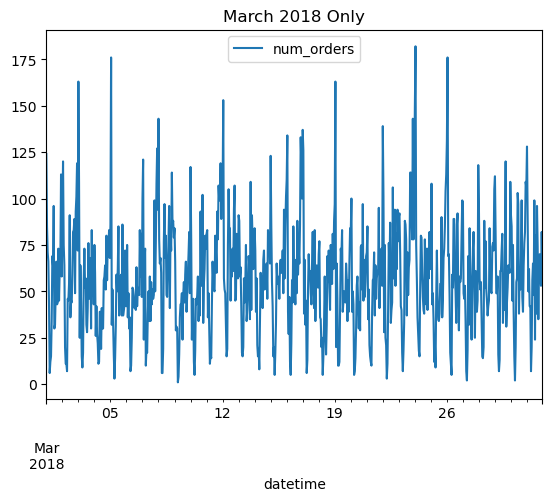

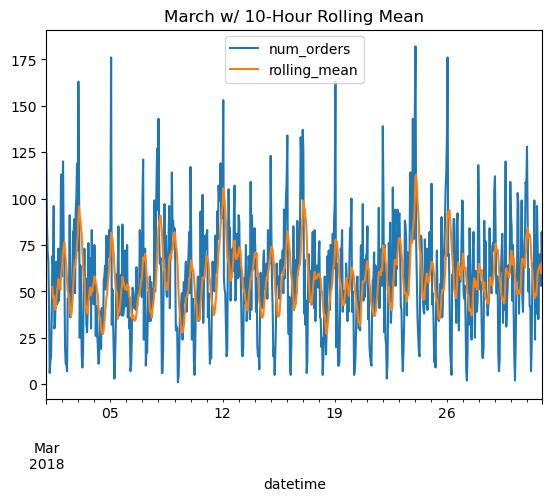

In [14]:
# Resample
df = df.resample('1H').sum().astype(float).fillna(0)
df.plot()
print()
eda_df = df['2018-03-01' : '2018-03-31'].copy()
eda_df.plot(title='March 2018 Only')
print()
eda_df['rolling_mean'] = eda_df['num_orders'].rolling(10).mean()
eda_df[['num_orders', 'rolling_mean']].plot(title='March w/ 10-Hour Rolling Mean')

- The data was resampled to an hourly interval as required for the model by Sweet Lift Taxi.
- Visualizing the data plotted over the entire duration reveals a subtle shift upwards of the mean between January and August.
- Though the data is not stationary in the most pure sense, it is fairly stable and slow in terms of upward trend, so for EDA purposes and seasonal decomposition, we'll examine data sliced just for the month of March.
- At first glance, there appears to be some repetition in both the raw data and the rolling mean, as can be seen in second and third visuals above.

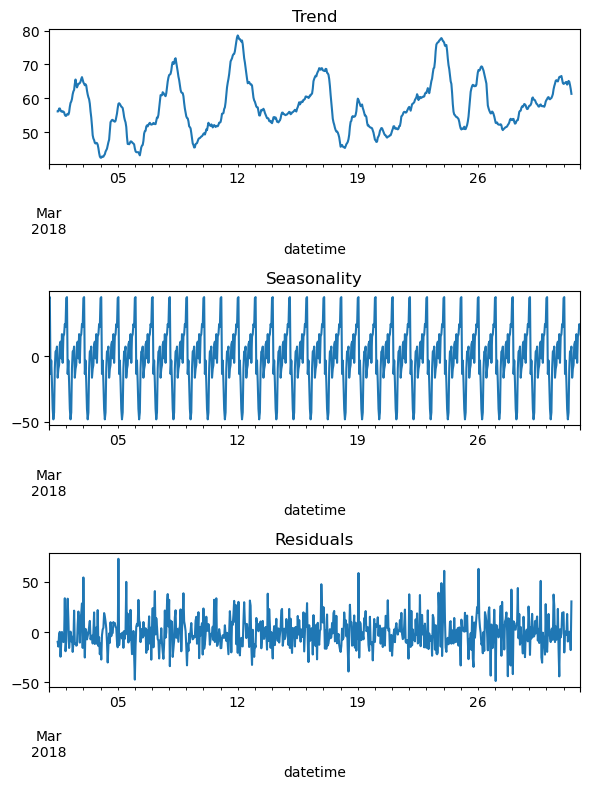

In [15]:
# Check trends and seasonality
eda_df = eda_df.drop('rolling_mean', axis=1)

decomposed = seasonal_decompose(eda_df)

plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- In the month of March EDA data slice, we an observe that there is a very subtle trend upwards as the month goes on, (on a very subtle level) the average number of hourly orders increases.
- There is a clear and present daily seasonality, where there is predictability on peak taxi ordering times on nay given time of day.
- The residuals in this particular slice of data are centered around the mean, which suggests that the non-stationarity of the data is very slight.

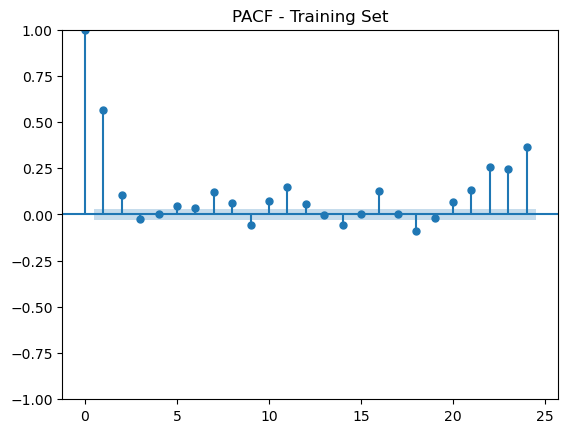


Lags that define the AR model order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]



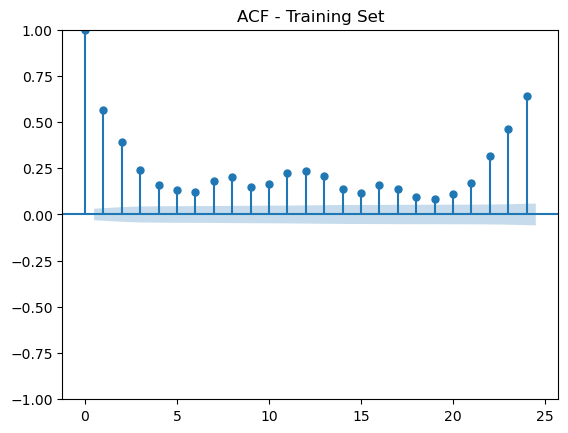


Output of the arma_order_select_ic() function is: (np.int64(0), np.int64(6))

ADF Statistic: -4.1728
p-value: 0.0007
Critical Values:
   1%: -3.4320
   5%: -2.8623
   10%: -2.5672


In [16]:
# Train/test split
train, test = train_test_split(
    df.copy(), test_size=0.10, shuffle=False
)

# PACF for AR order selection (p)
lags_to_check = 24
plot_pacf(train, lags=lags_to_check)
plt.title('PACF - Training Set')
plt.show()
print()
mod = ar_select_order(endog=train, maxlag=lags_to_check)
ar_order = mod.ar_lags
print(f'Lags that define the AR model order: {ar_order}')
print()

# ACF for MA order selection (q)
lags_to_check = 24
plot_acf(train, lags=lags_to_check)
plt.title('ACF - Training Set')
plt.show()
print()
res = arma_order_select_ic(y=train, max_ar=0, max_ma=6)
ma_order = res.bic_min_order[1]
print(f'Output of the arma_order_select_ic() function is: {res.bic_min_order}')
print()

# ADF testing for stationarity (d)
print_adf_result(train)

For the purposes of EDA and potential insight prior to training, a copy of `df` was made and split using the `train_test_split` method to simply observe if there was any basic structure that could be gleaned from the time series.

__PACF (AR Order, _p_):__
- There is a strong statistical spike at lags 1 and 2, followed by smaller but signficant lags across the range.
- The `ar_select_order` function found lags 1 through 24 relevant, suggesting a complex and seasonal structure.

__ACF (MA Order, _q_):__
- There is a gradual decline with several signficant lags, followed by pickup at the seasonal boundaries towards the end at lag 24.
- The `arma_order_select_ic` function picked 6, also suggesting the seasonality of the model.

## Feature Engineering  

In [17]:
def make_features(series, lags=(1, 24), rollings=(3, 24)):
    """
    Build ML-friendly feature table from a 1D time series.
    Returns a DataFrame with:
        - target columns: 'num_orders', 'log_target'
        - calendar: hour, dayofweek, is_weekend
        - lag features: lag_*
        - rolling means: roll_*
    """
    feat = series.to_frame(name='num_orders').copy()
    # calendar
    feat['hour'] = feat.index.hour
    feat['dayofweek'] = feat.index.dayofweek
    feat['is_weekend'] = (feat['dayofweek'] >= 5).astype(int)

    # lags
    for L in lags:
        feat[f'lag_{L}'] = feat['num_orders'].shift(L)

    # rollings
    for W in rollings:
        feat[f'roll_{W}'] = feat['num_orders'].rolling(W).mean()

    # drop rows that became NaN due to lag/rolling
    feat = feat.dropna()

    # log target (train in log-space; evaluate after inverse)
    feat['log_target'] = np.log1p(feat['num_orders'])
    
    return feat

feat = make_features(df['num_orders'], lags=(1, 2, 24), rollings=(3, 6, 24))

- Prior to prepping for training, several features will be created and added to the dataset to enrich the model in the flexible `make_features` wrapper above.
- These features include calendar type columns, as well as modules for lags and rolling shifts.
- Additionally, the wrapper handles the removal of NaNs that may occur depending on the lag or rolling scheme.
- The dataset shall be tested in the logarithmic space before final assessment with the raw data to mitigate the impact of noise and non-value-add spiking.
- The final line of code executes the `make_features` wrapper on `df` with the training lags and rollings assessed above. 

## Train/Test Splits

In [18]:
# Feature columns
feature_cols = [c for c in feat.columns if c not in ('num_orders', 'log_target')]

n = len(feat)
train_end = int(n * 0.80)
val_end = int (n * 0.90)

feat_train = feat.iloc[:train_end].copy()
feat_val = feat.iloc[train_end:val_end].copy()
feat_test = feat.iloc[val_end:].copy()

# log space training variables
x_train = feat_train[feature_cols]
x_val = feat_val[feature_cols]
x_test = feat_test[feature_cols]

# log targets
targ_train_log = feat_train['log_target']
targ_val_log = feat_val['log_target']
targ_test_log = feat_test['log_target']

# raw targets
targ_train = feat_train['num_orders']
targ_val = feat_val['num_orders']
targ_test = feat_test['num_orders']

- This code begins by explicitly defining the feature columns, as well as carving out the exact start and end of each of the training, validation, and test sets.
- As the model will be trained and validated in the logarithmic space to mitigate noise and spiking, followed by assessment in the raw, both sets of targets have been predefined for the three datasets above.
- As the Project Charter requires, the training set and validation set shall be comprised of 90% of `df`, with the most recent 10% to be held out until final testing.
- Splitting the data in the manner above ensure that there is no break in the chronological order from training through test, which is critical for time series modeling.

## Model Evaluation Prep

In [19]:
def eval_AR(lags=24):
    y_tr = targ_train_log.copy()
    y_va = targ_val_log.copy()

    model = AutoReg(y_tr, lags=lags, old_names=False)
    fit = model.fit()
    preds_log = fit.predict(start=y_va.index[0], end=y_va.index[-1])

    preds = expm1_clip(preds_log)
    return rmse(targ_val.values, preds), fit

def eval_MA(q=24):
    # MA(q) == ARIMA(0, 0, q) on log target
    y_tr = targ_train_log.copy()
    y_va = targ_val_log.copy()

    fit = ARIMA(y_tr, order=(0, 0, q)).fit()
    preds_log = fit.predict(start=y_va.index[0], end=y_va.index[-1])

    preds = expm1_clip(preds_log)
    return rmse(targ_val.values, preds), fit

def eval_ARIMA(p=2, d=0, q=2):
    y_tr = targ_train_log.copy()
    y_va = targ_val_log.copy()

    fit = ARIMA(y_tr, order=(p,d,q)).fit()
    preds_log = fit.predict(start=y_va.index[0], end=y_va.index[-1])

    preds = expm1_clip(preds_log)
    return rmse(targ_val.values, preds), fit

def eval_LGBM(n_estimators=600, learning_rate=0.05, max_depth=-1, num_leaves=31):
    x_tr = x_train.copy()
    x_va = x_val.copy()
    y_tr = targ_train_log.copy()
    y_va = targ_val_log.copy()

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        random_state=random_state
    )
    model.fit(x_tr, y_tr)
    preds_log = model.predict(x_va)
    preds = expm1_clip(preds_log)
    return rmse(targ_val.values, preds), model

- The code above places the model candidates in flexible wrappers that allow for flexible changing of hyperparameters where needed.
- All wrappers work off of individual copies of the training dataset to ensure that there is no leakage or contamination across models.
- Included in the testing line up are:
    - __Autoregression (AR, p=24)__
    - __Moving Average (MA, q=24)__
    - __ARIMA (p=2, q=2)__
    - __LightGBM Regression__
- All model wrappers involve training in the logarithmic space, followed by conversion to the raw state for final assessment using the `expm1_clip` wrapper.

## Model Training & Validation

In [20]:
results = {}

ar_rmse, ar_fit = eval_AR(lags=24)
results['AR(24)'] = ar_rmse

ma_rmse, ma_fit = eval_MA(q=24)
results['MA(24)'] = ma_rmse

arima_rmse, arima_fit = eval_ARIMA(p=2, d=0, q=2)
results['ARIMA(2,0,2)'] = arima_rmse

lgb_rmse, lgb_fit = eval_LGBM(
    n_estimators=800, learning_rate=0.04, num_leaves=63
)
results['LightGBM'] = lgb_rmse

print("Validation RMSEs")
for name, score in results.items():
    print(f"{name:>14}: {score:.2f}")

best_name = min(results, key=results.get)
print(f"\nBest on validation: {best_name} (RMSE={results[best_name]:.2f})")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 3513, number of used features: 9
[LightGBM] [Info] Start training from score 4.176287
Validation RMSEs
        AR(24): 53.90
        MA(24): 64.97
  ARIMA(2,0,2): 65.25
      LightGBM: 19.56

Best on validation: LightGBM (RMSE=19.56)


- All of the models were trained on the first 80% of the data, and the validated on the next 10% in chronological order from copies of `df`.
- All models with the expection of __`LightGBM`__ struggled to meet the required __RMSE__ of 48, where `LightGBM` far exceeded the target with 19.56 in training/validation.
- As such, `LightGBM Regression` shall be used in the next codebloc for final testing.

## Refit on Training/Validation Sets & Final Testing

In [21]:
# Combine train+val
x_trv = pd.concat([x_train, x_val], axis=0)
y_trv_log = pd.concat([targ_train_log, targ_val_log], axis=0)

if best_name.startswith('AR('):
    lags = int(best_name.split('(')[1].split(')')[0])
    final_fit = AutoReg(y_trv_log, lags=lags, old_names=False).fit()
    preds_log_test = final_fit.predict(start=targ_test_log.index[0], end=targ_test_log.index[-1])

elif best_name.startswith('MA('):
    q = int(best_name.split('(')[1].split(')')[0])
    final_fit = ARIMA(y_trv_log, order=(0,0,q)).fit()
    preds_log_test = final_fit.predict(start=targ_test_log.index[0], end=targ_test_log.index[-1])

elif best_name.startswith('ARIMA'):
    inside = best_name.split('(')[1].split(')')[0]
    p, d, q = map(int, inside.split(','))
    final_fit = ARIMA(y_trv_log, order=(p,d,q)).fit()
    preds_log_test = final_fit.predict(start=targ_test_log.index[0], end=targ_test_log.index[-1])

else:  # LightGBM
    final_fit = LGBMRegressor(
        n_estimators=800, learning_rate=0.04, num_leaves=63,
        random_state=random_state
    )
    final_fit.fit(x_trv, y_trv_log)
    preds_log_test = final_fit.predict(x_test)

# Inverse transform + test RMSE in original units
preds_test = expm1_clip(preds_log_test)
test_rmse = rmse(targ_test.values, preds_test)
print(f"\nFinal Test RMSE (held-out last 10%): {test_rmse:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 9
[LightGBM] [Info] Start training from score 4.226241

Final Test RMSE (held-out last 10%): 31.41


- To ensure that the testing of the `LightGBM Regression` model is as accurate as possible, the training and validation sets were concatenated into one continuous training set again.
    - This ensure that the first 90% of the data is assessed in chronological order.
- Though we determined that `LightGBM Regression` was the winner in training, a flexible `if/elif/else` wrapper was prepared to capture the `best_name` variable in the prior training assessment codeblock to flexibly test whatever model emerged as the winner in training.
- Though the __RMSE__ increased slightly to 31.41 in test, `LightGBM Regression` remains a standout model and is well under the test target of 48.

## Conclusion

__Project Objectives:__
- Provide a time-series forecasting model to aid __Sweet Lift Taxi__ in reliably predicting the number of taxi orders from hour to hour using historical data containing airport taxi orders
- The test RMSE cannot exceed 48.

__Results Summary:__
- Across all candidate models, LightGBM Regression delivered the strongest performance in validation (RMSE = 19.56), substantially outperforming the AR(24), MA(24), and ARIMA(2,0,2) benchmarks, all of which exceeded the 48 RMSE target.
- For final testing, training and validation data were combined to preserve chronological order (first 90% for training, final 10% for testing), ensuring temporal integrity.
- On the held-out test set, LightGBM’s RMSE rose modestly to 31.41, yet remained well below the required threshold of 48, confirming its robustness and generalization capability.
- The model’s ability to capture both short-term dependencies and nonlinear relationships makes it the most effective solution for this forecasting task.

__Next Steps & Recommendations:__
- Deploy LightGBM as the production model, with automated retraining scheduled periodically to incorporate new data.
- Monitor RMSE and other performance metrics over time to detect any drift in model accuracy.
- Explore feature engineering opportunities (such as additional lagged variables, seasonal indicators) to further enhance predictive power.